### SOLID: a Framework of Synergizing Optimization and Large Language Models for Intelligent Decision-Making
Authors: Yinsheng Wang, Tario You, Léonard Boussioux

In this model, we build two agents to decide an investment strategy for a portfolio of stocks.
For simplicity, we assume that the portfolio consists of 4 stocks: NVDA, GOOG, MSTR, and SMCI.
The first agent is a mean-variance optimization model. It aims to minimize the portfolio variance while achieving a target return.
The second agent is a GPT-based Language Model. Through prompt-based learning, it aims to generate a portfolio strategy that maximizes the portfolio return.
The two agents will communicate with each other to reach a consensus on the portfolio strategy, i.e., the portfolio weights for the two stocks.

#### Import necessary libraries

In [151]:
from openai import OpenAI
import json
import pandas as pd
from tqdm import tqdm
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import risk_models
import numpy as np
import matplotlib.pyplot as plt
import json
from typing import List
from openai import OpenAI
import os
import re
import pandas as pd
from tqdm import tqdm
import yfinance as yf
from gurobipy import Model, GRB, quicksum
import warnings
from dotenv import load_dotenv
import matplotlib.colors as mcolors
from IPython.display import display

load_dotenv()

warnings.filterwarnings('ignore')

pd.set_option('display.expand_frame_repr', False)  # Prevent splitting
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_rows', None)           # Optional: Show all rows

api_key = os.getenv("PPLX")

# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "WMT"] # 1
# tickers = ["AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 2
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE"] # 3
# tickers = ["NVDA", "GOOG", "MSTR", "SMCI", "TSLA", "AAPL", "JPM", "XOM", "JNJ", "WMT", "HD", "AMT", "BA", "NEE", "V"] # 4
# tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "META", "JPM", "XOM", "UNH", "WMT", "HD", "CAT", "PLD", "NEE", "V", "AMD"] # 6% better
# tickers = ["MS", "BAC", "CVX", "PFE", "PEP", "COST", "NFLX", "INTC", "LMT", "CSCO", "AXP", "AMZN", "TMUS", "TM", "DUK"]
# tickers = ["CVX", "PFE", "NFLX", "LMT", "TM", "PLTR", "OKTA", "MAR", "MCD", "SBUX", "EBAY", "MRNA", "BHP", "TGT", "EOG"]
tickers = [
    'NVDA', 'AMD', 'MSFT', 'AAPL', 'INTC', 'PLTR',  # Technology
    'TSLA', 'AMZN', 'SBUX', 'TGT', 'NFLX', 'MCD',  # Consumer Discretionary
    'HOOD', 'BAC', 'JPM', 'MS', 'V', 'SCHW',  # Financials
    'ZG', 'PLD', 'WELL', 'SPG', 'PSA', 'EQR',  # Real Estate CTRYF AMT
    'GEV', 'XOM', 'DUK', 'NEE', 'EOG', 'SLB',  # Energy
    'TEM', 'UNH', 'PFE', 'MRNA', 'ABBV', 'MDT',  # Healthcare
    'CAT', 'BA', 'LMT', 'DE', 'GD', 'HON',  # Industrials
    'PCT', 'NEM', 'LIN', 'APD', 'FCX', 'MLM',  # Materials
    'GOOG', 'TMUS', 'META', 'DIS', 'VZ', 'CMCSA',  # Communication Services
    'COST', 'PEP', 'WMT', 'KO', 'PG', 'MO'  # Consumer Staples JSAIY
]

stock_categories = [
    "Technology",
    "Consumer Discretionary",
    "Finance",
    "Real Estate",
    "Energy", 
    "Healthcare",
    "Industrial",
    "Material",
    "Communication",
    "Consumer Staples"
]

In [84]:
# CHANGE THESE!!
appendage = "nvda60_prompt"
iteration = 2

# always just appends
init_news_path = f"assets/init_news_reports.json"
stock_data_path = f"assets/stock_data.json"

pft_path = f"assets/portfolio_{appendage}.csv"
stock_price_history_image_path = f'figures/stock_price_history_{appendage}.png'

grid_image_path = f'assets/output_{appendage}_{iteration}.png'
weights_coord_path = f"assets/weights_coord_{appendage}_{iteration}.json"
weights_llm_path = f"assets/weights_llm_{appendage}_{iteration}.json"
weights_opt_path = f"assets/weights_opt_{appendage}_{iteration}.json"
pft_value_over_time_path = f'figures/pft_value_over_time_{appendage}_{iteration}.png'
main_file_path = f"main_{appendage}_{iteration}.ipynb"

rerun_opt, rerun_llm, rerun_coord = True, True, True

#### Functions to save data locally

In [85]:
def save_data(data, file_path=stock_data_path):
    """
    Saves the dictionary 'data' to a JSON file at 'file_path'.
    """
    with open(file_path, 'w') as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {file_path}")

def load_data(file_path=stock_data_path):
    """
    Loads JSON data from 'file_path' and returns it as a dictionary.
    """
    with open(file_path, 'r') as fp:
        data = json.load(fp)
    print(f"Data loaded from {file_path}")
    return data

def patch_data(
    tickers,
    file_path=stock_data_path
):
    """
    Load existing data from file_path, then patch each month's dictionary
    to include 'MSTR' and 'SMCI' using Perplexity.ai's OpenAI-like client calls.
    Finally, save the patched data back to file_path.
    """

    # 1) Load the existing data
    data = load_data(file_path)

    # 2) Set up your client, months, system prompt, etc.
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")

    months = [
        "January", "Febuary", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    
    system_prompt = {
        "role": "system",
        "content": (
            "Show me key news on [Company X] (I'll provide you the stock ticker) from [Date Range]. This list isn't exhaustive—earnings, leadership changes, regulatory updates, major headlines, M&A, industry trends, product launches, analyst opinions, investor activism, competitor moves—but only pick what's most representative for [Company X]'s stock performance. If other items seem more important, include them. Summarize in bullet points; avoid complete sentences; aim for maximum information. You don't have to include everything, just the key pieces. Keep final summary around 400 words."
        )
    }

    # 3) Patch each month's dictionary if tickers dont exist
    for i, monthly_data in enumerate(data):
        for j in tqdm(range(len(tickers))):
            ticker = tickers[j]
            if ticker not in monthly_data:
                # Build the request messages for the missing ticker
                messages = [
                    system_prompt,
                    {
                        "role": "user",
                        "content": f"What happened to {ticker} in {months[i]} 2024?"
                    }
                ]

                # Make the API call
                response = client.chat.completions.create(
                    model="llama-3.1-sonar-large-128k-online",
                    messages=messages,
                )

                # Save the result in the monthly dictionary
                monthly_data[ticker] = {"news": response.choices[0].message.content}
                # print(f'patched: month {months[i]}\t{ticker}')
            # else:
                # print(f'skipping: {ticker}')
            
            # save_data(data, file_path)

    # 4) Save the patched data back to the JSON file
    save_data(data, file_path)

#### Using Perplexity to gather news about the tickers

In [86]:
client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
months = ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
data = [
    # Jan
    # {
    #     "MSFT":{
    #         "news": "yay", # news for all of Jan
    #         "price": 20 # last day's closing price - Jan 31
    #     }
    # }
]

#### Loading the S&P 500 tickers

In [87]:
file_path = 'assets/constituents.csv'
data = pd.read_csv(file_path)
constituents = data['Symbol'].tolist()

# constituents

#### Patching data for tickers

In [88]:
patch_data(tickers)
# S&P 500: patch_data(constituents)

Data loaded from assets/stock_data.json


100%|██████████| 60/60 [00:00<00:00, 451000.43it/s]

Data saved to assets/stock_data.json


#### Initial stock introductions

In [89]:
def load_init_news_reports():
    with open("assets/init_news_reports.json", "r") as f:
        stock_reports = json.load(f)
    return stock_reports

def save_init_news_reports(init_news_reports):
    with open("assets/init_news_reports.json", "w") as f:
        json.dump(init_news_reports, f, indent=4)

def patch_init_news_reports():
    client = OpenAI(api_key=api_key, base_url="https://api.perplexity.ai")
    
    init_news_reports = load_init_news_reports()
    for ticker in tickers:
        if ticker not in init_news_reports:

            messages = [
                {
                    "role": "system",
                    "content": "You analyze and summarize companies."
                },
                {
                    "role": "user",
                    "content": f"Give me a 100 word summary about the stock ticker {ticker}"
                }
            ]

            response = client.chat.completions.create(
                model="llama-3.1-sonar-large-128k-online",
                messages=messages,
            ) 

            init_news_reports[ticker] = response.choices[0].message.content

    save_init_news_reports(init_news_reports)

patch_init_news_reports()

#### Get ticker prices

In [90]:
def get_last_trading_day_of_month(year, month, exchange='NYSE'):
    # Create a calendar for the specified exchange
    calendar = mcal.get_calendar(exchange)
    
    # Get the last day of the specified month
    if month == 12:
        last_day = datetime.datetime(year + 1, 1, 1) - datetime.timedelta(days=1)
    else:
        last_day = datetime.datetime(year, month + 1, 1) - datetime.timedelta(days=1)
    
    # Get the schedule for the month
    schedule = calendar.schedule(start_date=f"{year}-{month:02d}-01", end_date=last_day)
    
    # If the schedule is empty, there were no trading days this month
    if schedule.empty:
        return None
    
    # Return the last trading day
    return schedule.index[-1].date().day

def get_stock_price(tickers, date):
    prices = yf.download(tickers, start=date, end=date + datetime.timedelta(days=1))
    prices = prices["Adj Close"].dropna(how="all")
    prices = prices.values.tolist()
    return prices[0]

def get_closing_prices(data_loaded):
    year = 2024
    for month in range(1, 13):
        date = get_last_trading_day_of_month(year, month)
        datetime_obj = datetime.datetime(year, month, date)
        
        missing_tickers = []
        missing_indices = []
        for i, ticker in enumerate(tickers):
            ticker_data = data_loaded[month-1][ticker]
            if "price" not in ticker_data:
                missing_tickers.append(ticker)
                missing_indices.append(i)
            else:
                if np.isnan(ticker_data['price']):
                    missing_tickers.append(ticker)
                    missing_indices.append(i)

        if missing_indices:
            prices = get_stock_price(missing_tickers, datetime_obj)
            if type(prices) != type([]):
                prices = [prices]

            for i, (ticker, j) in enumerate(zip(missing_tickers, missing_indices)):
                data_loaded[month-1][ticker]['price'] = prices[i]

    save_data(data_loaded)

# get_stock_price('ZG', datetime.datetime(2024, 1, get_last_trading_day_of_month(2024, 1)))

data_loaded = load_data()
get_closing_prices(data_loaded)

Data loaded from assets/stock_data.json
Data saved to assets/stock_data.json


#### Getting the tickers' historical prices for the optimizer
This is not just closing price at the end of each month like above, it's the entire data for a year

In [91]:
leo_key = os.getenv("CHAT")

client = OpenAI(
    api_key=leo_key,
)

def get_stock_price(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)
    prices = prices["Adj Close"].dropna(how="all")
    return prices

start_date = datetime.datetime(2024, 1, 1)
end_date = datetime.datetime.today().date()

portfolio = get_stock_price(tickers, start_date, end_date)
portfolio.to_csv(pft_path, index=True)
portfolio = pd.read_csv(pft_path, parse_dates=True, index_col="Date")

[*********************100%%**********************]  60 of 60 completed


#### Historical ticker prices

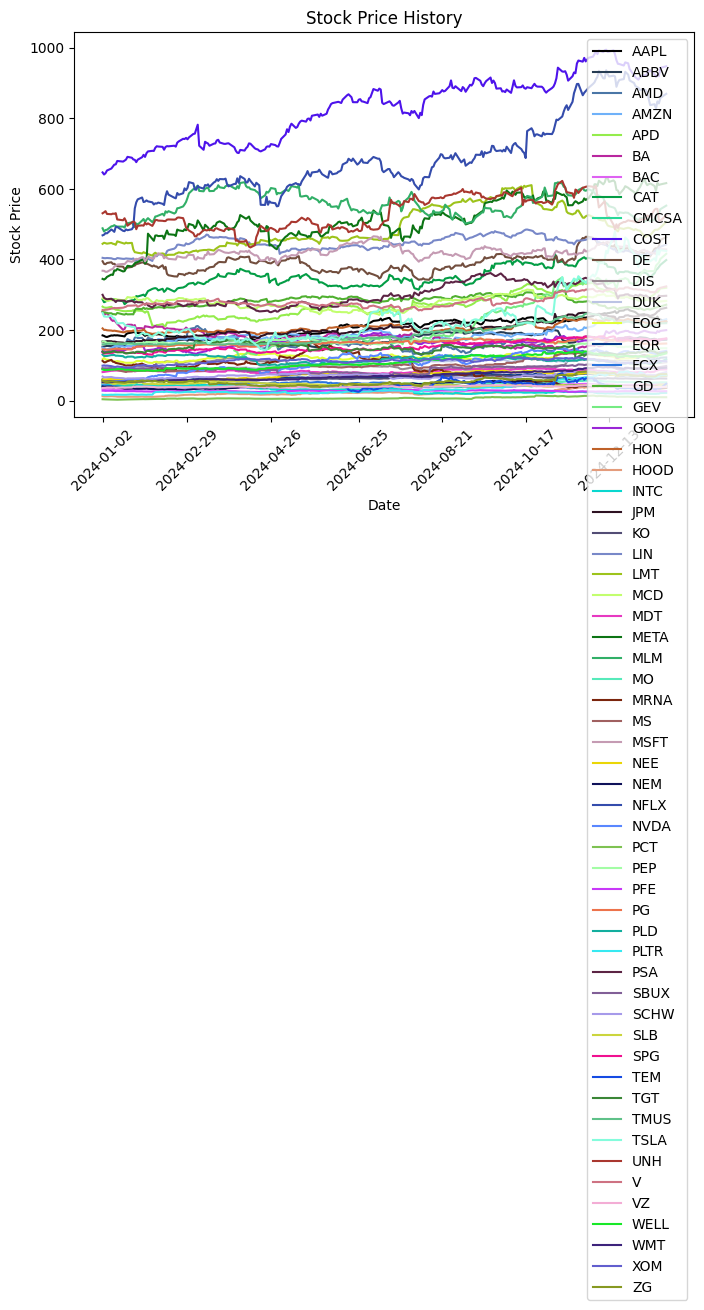

In [92]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

df = portfolio

# Function to generate a list of colors by iterating through RGB values
def generate_colors(n_colors):
    colors = []
    for i in range(n_colors):
        r = (i * 37) % 256 / 255.0  # Example formula for varying red
        g = (i * 59) % 256 / 255.0  # Example formula for varying green
        b = (i * 83) % 256 / 255.0  # Example formula for varying blue
        colors.append((r, g, b))
    return colors

# Generate unique colors based on the number of columns
colors = generate_colors(len(df.columns))

# Plot
plt.figure(figsize=(8, 5))

# Plot each column with a unique color
for idx, column in enumerate(df.columns):
    plt.plot(df.index, df[column], label=column, color=colors[idx])

# Formatting the x-axis
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price History")
plt.legend()

tick_indices = df.index[::40]  # Select every 60th index
plt.xticks(tick_indices, [date.strftime('%Y-%m-%d') for date in tick_indices], rotation=45)

plt.tight_layout()

# Save the plot
plt.savefig(stock_price_history_image_path, dpi=500, bbox_inches='tight')

# Show the plot
plt.show()


Expected annual return: 41.4%
Annual volatility: 14.9%
Sharpe Ratio: 2.64


AAPL     0.205377
ABBV     0.118692
AMD      0.527247
AMZN     0.354821
APD      0.203013
BA       0.276999
BAC      0.310337
CAT      0.381946
CMCSA    0.226057
COST     0.200707
DE       0.263240
DIS      0.215636
DUK      0.103475
EOG      0.162138
EQR      0.231184
FCX      0.385322
GD       0.191004
GEV      0.582961
GOOG     0.275524
HON      0.204817
HOOD     0.827185
INTC     0.652201
JPM      0.301480
KO       0.070208
LIN      0.182195
LMT      0.083908
MCD      0.151464
MDT      0.179270
META     0.293461
MLM      0.324560
MO       0.100200
MRNA     0.511395
MS       0.380436
MSFT     0.248587
NEE      0.190655
NEM      0.294183
NFLX     0.275759
NVDA     0.462831
PCT      0.790654
PEP      0.072957
PFE      0.161507
PG       0.056954
PLD      0.325567
PLTR     0.707661
PSA      0.236217
SBUX     0.285203
SCHW     0.251811
SLB      0.289515
SPG      0.291006
TEM      1.734234
TGT      0.261195
TMUS     0.126441
TSLA     0.699677
UNH      0.126761
V        0.196804
VZ       0

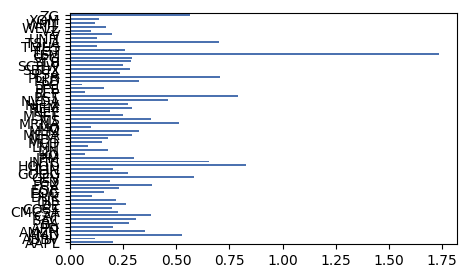

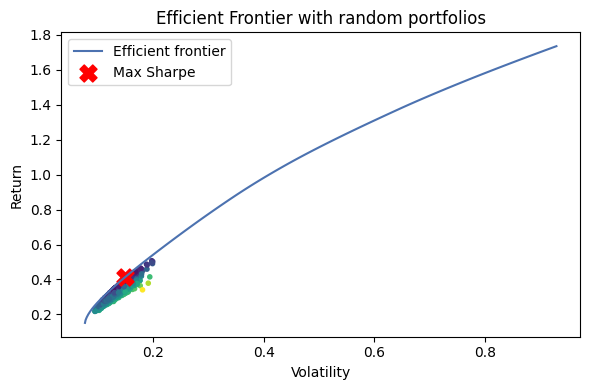

In [93]:
sample_cov = risk_models.sample_cov(portfolio, frequency=252)

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
mu = expected_returns.capm_return(portfolio)

mu.plot.barh(figsize=(5, 3))

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True)


latest_prices = get_latest_prices(portfolio)

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)

# Number of shares of each stock to purchase
allocation, leftover = da.greedy_portfolio()

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(6, 4))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Max Sharpe')

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()

mu

#### Generate initial stock info

In [94]:
with open(init_news_path, "r") as f:
    stock_reports = json.load(f)
stock_reports

{'NVDA': "NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.",
 'GOOG': "Alphabet Inc. is the parent company of Google, created through a restructuring in 2015. As one of the world's largest technology companies, Alphabet is headquartered in Mountain View, California. The company's primary revenue 

In [95]:
# brief stock introductions obtained from Perplexity.ai
def generate_data_summary(reports):
    summary = f"Recent reports indicate:\n"
    for ticker in tickers:
        report = reports[ticker]
        summary += f"For {ticker}:\n{report}\n\n"
    return summary

initial_stock_info = generate_data_summary(stock_reports)

#### Dynamic YF stock data storage
pre download the data

In [96]:
# get the data
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2025, 1, 1)
prices = yf.download(tickers, start=start_date, end=end_date)
portfolio = prices["Adj Close"].dropna(how="all")
portfolio.to_csv(pft_path, index=True)

[*********************100%%**********************]  60 of 60 completed


In [97]:
# demonstration of the data being got
portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
start_date = datetime.datetime(2023, 12, 1)
end_date = datetime.datetime(2023, 12, get_last_trading_day_of_month(2023, 12))
df_subset = portfolio.loc[start_date:end_date]
df_subset

AAPL        ABBV         AMD        AMZN         APD          BA        BAC         CAT      CMCSA        COST          DE        DIS        DUK         EOG        EQR        FCX          GD  GEV        GOOG         HON   HOOD       INTC         JPM         KO         LIN         LMT         MCD        MDT        META         MLM         MO        MRNA         MS        MSFT        NEE        NEM        NFLX       NVDA    PCT         PEP        PFE          PG         PLD       PLTR         PSA       SBUX       SCHW        SLB         SPG  TEM         TGT        TMUS        TSLA         UNH           V         VZ       WELL        WMT        XOM         ZG
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2023-12-01  190.307678  137.060013  121.389999  147.029999  263.875153  233.869995  30.191700  251.783844  40.636681  579.607544  362.007599  91.450264  89.005692  117.740883  55.721302  38.601406  243.451202  NaN  132.842697  193.644821   9.32  43.161938  152.395050  56.902119  406.739105  437.944641  279.194122  77.369759  323.583954  464.845337  38.324417   79.830002  78.047150  371.730286  57.495758  40.197464  465.739990  46.747631  4.630  163.455658  27.244610  148.951797  113.803810  20.270000  253.026276  96.678329  62.238163  50.857098  120.769409  NaN  130.896698  150.036575  238.830002  538.725220  254.504669  35.540035  87.397285  50.649208  99.592751  41.650002
2023-12-04  188.506470  137.767242  118.570000  144.839996  261.465240  234.869995  30.055172  249.812805  41.474258  582.358521  362.125366  90.887215  89.092163  117.169342  55.864075  36.997929  245.908218  NaN  130.162308  194.212692   9.55  41.790306  153.512451  56.834190  401.740082  439.191956  279.360077  77.147301  318.802216  461.742065  38.234455   79.870003  78.355904  366.400116  57.009903  39.553524  453.899994  45.493099  4.650  163.891708  27.593296  148.366379  115.795815  18.400000  256.165344  95.119011  61.725750  50.507633  122.672554  NaN  129.857559  150.578598  235.580002  539.828064  252.509903  35.042583  87.748993  50.636078  99.051216  42.330002
2023-12-05  192.477051  138.168640  118.379997  146.880005  253.596542  234.160004  29.821129  250.244278  40.059048  588.453491  354.479095  89.682106  88.842361  116.169106  55.445263  35.974857  244.621201  NaN  131.916016  192.832169  10.53  41.365990  153.493027  56.921524  399.102234  434.855499  279.760406  76.238083  317.078796  456.788757  38.297432   78.279999  77.352455  369.754974  56.582355  38.919342  455.149994  46.552803  3.990  162.728912  27.414240  143.195099  114.179108  18.299999  255.718277  93.111366  61.321739  49.366383  122.606918  NaN  129.051468  151.761139  238.720001  541.777527  252.678619  35.392639  87.807610  51.105358  97.126869  42.520000
2023-12-06  191.382416  139.898514  116.820000  144.520004  252.880386  236.889999  29.772371  251.009171  40.136063  590.475464  358.797913  90.383430  90.254692  114.073387  55.464302  35.660065  245.654709  NaN  130.959427  193.654617  11.27  40.724583  151.880051  56.863300  395.486389  437.944641  280.072815  76.450882  316.241974  458.012177  37.208874   80.599998  76.619164  366.062622  58.496613  38.724209  446.730011  45.490101  4.120  162.312256  27.131523  143.087769  114.564041  17.129999  256.507751  94.553757  61.252754  47.922749  123.497543  NaN  129.537048  153.239334  239.369995

#### Main class to integrate the LLM with the Portfolio Optimization model

In [147]:
class bcolors:
    PURPLE = '\033[95m'
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'

In [152]:
class CoordinationFramework():
    def __init__(self, mu, Q, target_return, penalty=1, iteration=2, verbose=False):
        """
        Initialization of the class for coordination framework
        :param np.array mu: expected return of the stocks
        :param np.array Q: covariance matrix of the stocks
        :param float target_return: target return of the portfolio
        :param float penalty: penalty term in coordination algorithm
        :param float iteration: number of iteration of coordination algorithm
        """
        # Store the init params so we can restore them later
        self._init_mu = mu
        self._init_Q = Q
        self._init_target_return = target_return
        self._init_penalty = penalty
        self._init_iteration = iteration
        self._init_verbose = verbose

        # Now do the usual initialization
        self.mu = mu  # expected return
        self.Q = Q.to_numpy()  # covariance matrix
        self.n = len(mu)  # number of stocks
        self.target_return = target_return

        self.penalty = penalty
        self.iteration = iteration
        self.verbose = verbose

        # initialization
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    def reset_variables(self):
        """
        Reset all variables to their initial values, exactly as they were in __init__.
        """
        # Restore parameters
        self.mu = self._init_mu
        self.Q = self._init_Q.to_numpy()  
        self.n = len(self._init_mu)
        self.target_return = self._init_target_return

        self.penalty = self._init_penalty
        self.iteration = self._init_iteration
        self.verbose = self._init_verbose

        # Reinitialize mutable state variables
        self.current_plan = [0.0] * self.n
        self.optimization_plan = [0.0] * self.n
        self.LLM_plan = [0.0] * self.n
        self.optimization_price = [0.0] * self.n
        self.LLM_price = [0.0] * self.n

        self.feedback_factor = 0.1

        self.plan_histories = []
        self.conversation_history = []
        self.conversation_summaries = []

    # In this function, the optimization model will update their preferred portfolio weights.
    def PortfolioOptimization_Agent(self, current_plan, verbose=False):
        # previous opt
        self.model = Model("mean_variance_optimization")
        self.model.setParam('OutputFlag', 0)
        # Add variables
        x = {}
        for i in range(self.n):
            x[i] = self.model.addVar(
                vtype=GRB.CONTINUOUS, name="x_{}".format(i))

        # Set objective
        obj = quicksum(self.Q[i, j] * x[i] * x[j]
                       for i in range(self.n) for j in range(self.n))
        dual = quicksum(
            self.optimization_price[i] * x[i] for i in range(self.n))
        penalty = self.penalty * \
            quicksum((x[i] - current_plan[i]) * (x[i] - current_plan[i])
                     for i in range(self.n))
        self.model.setObjective(obj + dual + penalty, GRB.MINIMIZE)

        # Add constraints
        self.model.addConstr(quicksum(x[i] for i in range(
            self.n)) == 1, "budget")  # budget constraint
        self.model.addConstr(quicksum(self.mu[i] * x[i] for i in range(
            self.n)) >= self.target_return, "target_return")  # target return constraint
        self.model.optimize()

        if verbose:
            print("\n[DEBUG] Building model with:")
            print(f"[DEBUG]   mu: {self.mu}")
            print(f"[DEBUG]   Q: {self.Q}")
            print(f"[DEBUG]   target_return: {self.target_return}")
            print("[DEBUG]   current_plan:", current_plan)
            print("[DEBUG]   optimization_price:", self.optimization_price)
            print("[DEBUG]   penalty:", self.penalty)
            print("[DEBUG]   x:", x)
            print("[DEBUG]   n:", self.n)
            
            self.model.write("debug/debug_model.lp")

            status = self.model.status
            print(f"[DEBUG] Gurobi optimization status: {status}")


        # Get results for portfolio weight on first stock
        weights = [x[i].x for i in range(self.n)]

        return weights

    def response_format(self):
        prompt = "please write your final recommendation in a single line, in the format below:\n\n"

        # Construct the label format dynamically based on the number of tickers.
        # Example of final output:  "AAPL: X1, MSFT: X2, AMZN: X3. Replace X1, X2, X3..."
        prompt += ", ".join([f"{ticker}: X{i+1}" for i, ticker in enumerate(tickers)])
        prompt += (
            ".\n\nReplace "
        )

        # Remind the model to replace placeholders with the actual confidence levels.
        prompt += ", ".join([f"X{i+1}" for i in range(len(tickers))])
        prompt += (
            " with the confidence level for each stock."
        )

        return prompt

    # In this function, the language model take the prompt as input and generate the preferred portfolio weights.
    def LLM_Agent(self, month_data, consensus_plan, month, iter, pure=False, verbose=False):
        system_prompt = """You are collaborating with an optimization model to develop an optimal portfolio strategy. The optimization model is an expert in numerical calculations and historical trend analysis, ensuring precision in minimizing risk and achieving target returns. Your role is to bring contextual understanding, strategic insights, and adaptability to the process.\nWhile you are encouraged to bring your unique perspective, remember:\n1. The optimization model has consistently outperformed by a significant margin (10-20%). Therefore, where substantial differences arise, you must carefully review the optimizer's proposal and adjust your recommendations unless you have a strong, data-backed reason to maintain your position.\n2. In this collaboration, flexibility and compromise are critical. Adapt your strategy when the optimizer provides strong evidence, as rigid decision-making has been shown to lead to suboptimal results.\n3. Your goal is to work synergistically with the optimizer to maximize overall portfolio performance. This requires understanding and integrating the optimizer's proposals to improve alignment.\n4. If you disagree, explicitly identify the key aspects of the optimizer's proposal that you are willing to accept or adjust. Never reject the optimizer’s strategy outright—focus on making incremental refinements."""
        if pure:
            system_prompt = "You're a very advanced stock trading expert with a deep understanding in the politics, economics, and business of companies in relation to their stock performance. When you see a news, you will know whether or not it will have a strong impact on your trader planning the next move of investment decisions. You always maximize the profit through your stock investments."
        messages = [
            {"role": "system", "content": system_prompt},
        ]
        messages.extend(self.conversation_history)

        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------
        current_prompt = ""

        if iter == 0:
            # Optionally include any initial stock info if this is the very first iteration.
            current_prompt += (
                f"{initial_stock_info}\n\n"
            )

        # for 60 stocks, exceeds 128k tokens
        # if month != 0 and len(self.conversation_summaries) != 0:
        #     current_prompt += "Here is what happened in the last few months for you to gain a background understanding of what happened:\n"
        #     current_prompt += "\n".join(self.conversation_summaries)
        #     current_prompt += "\n\n"

        if iter == 0:
            stock_prices = f"The stock prices today are:\n"
            for i, ticker in enumerate(tickers):
                ticker_close = month_data[ticker]['price']
                stock_prices += f"{ticker} = {ticker_close}"
                if i != len(tickers) - 1:
                    stock_prices += ", "
            stock_prices += "\n"

            stock_news = ""
            for ticker in tickers:
                ticker_news = month_data[ticker]['news']
                stock_news += f"news for {ticker}:\n{ticker_news}\n\n"

            # If this is the first iteration in a given month, include relevant news and price info.
            current_prompt += (
                "Please read the following information carefully.\n\n"
                f"---\n**Stock News**\n\n{stock_news}\n\n"
                f"---\n**Recent Stock Prices**\n\n{stock_prices}\n\n"
            )

        # Begin the main decision instructions.
        current_prompt += (
            "You are a trader responsible for making portfolio allocation decisions. "
            # "Use all relevant information provided (such as any past decisions, news, or stock data) to "
            "Use all relevant information provided (such as news and stock data) to "
            "decide how much to invest in each stock.\n\n"
            "Think about:\n"
            "1. Any news articles and how they might affect each stock.\n"
            # "2. Any patterns in recent price movements.\n"
            "2. Previous decisions you have made regarding portfolio weights.\n"
        )

        # If we're past the first iteration, include guidance about consensus plans.
        if iter != 0 and self.current_plan != [0.0] * self.n and not pure:
            current_prompt += (
                "Also, you are working with a optimization model that is very proficient in numerical calculations, and here is the current plan (portfolio allocation) you guys have worked" "out. Decided if you agree with this plan, then make the necessary adjustments to your own plan: "
                f"{self.current_plan}\n\n"
            )

        current_prompt += (
            f"Also, here is the decision-price of your plan thus far: {self.LLM_price}."
            "A higher decision-price means you should adjust your plan to be higher. And a negative decision-price means you should adjust your plan to be smaller."
        )

        # Ask the model for a recommendation. Emphasize the requirement to explain reasoning first, then provide the format.
        current_prompt += (
            "### Task\n"
            "1. Carefully evaluate the optimizer's proposed portfolio weights and explain your reasoning for agreement or disagreement. When in doubt, lean towards collaboration by adjusting your recommendations closer to the optimizer's.\n"
            "2. Finalize your recommendation in the following format: [Ticker: Confidence Level]:\n"
            "   - Very Low Confidence\n"
            "   - Low Confidence\n"
            "   - Somewhat Low Confidence\n"
            "   - Neutral\n"
            "   - Somewhat High Confidence\n"
            "   - High Confidence\n"
            "   - Very High Confidence\n\n"
            "3. Conclude by summarizing how your proposal aligns with the optimizer's and why it contributes to achieving the collective goals.\n"
            "Even if you are unsure, you **must** provide the best decision you can based on the available information.\n\n"
            "Take a deep breath and work on this problem step-by-step.\n"
            "### Response Format\n"
            "After your explanation, " + self.response_format() + ""
            "\nRemember, collaboration, adaptability, and performance are key to success."
        )

        
        # ------------------------------------------------------------------------------
        # ------------------------------------------------------------------------------


        if verbose:
            print(f"\n# month {month} iter {iter}")
            # print(f"prompt: \n{current_prompt}\n")

        messages.append({"role": "user", "content": current_prompt})

        result_dict = []
        retry_messages = [m for m in messages]
        attempt = 0
        retry = True
        retry_reason = ""
        missing_tickers = set(tickers)
        while retry:
            if attempt != 0:
                if retry_reason == "INVALID FORMAT":
                    new_message = "Sorry, I could not parse your response. Please try again with the correct specified formatting: " + self.response_format()

                    missing_tickers = set(tickers)
                elif retry_reason == "ZERO SUM":
                    new_message = "The sum of the weights for each stock cannot be 0. Please try again: " + self.response_format()
                    
                    missing_tickers = set(tickers)
                else: # "MISSING TICKER"
                    new_message = f"You missed a few tickers: {missing_tickers}. Give the confidence levels for them: "

                retry_messages.append({
                    "role": "user", 
                    "content": new_message
                })

                if verbose:
                    print(f"\n# month {month} iter {iter} {bcolors.RED}RETRY{bcolors.ENDC} because {retry_reason}") # PROMPT: \n{new_message}\n

            attempt += 1
            # Make an API call to ChatGPT with the prompt
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=retry_messages,
                temperature=0
            )

            # Parse the decision from the response
            text = response.choices[0].message.content
            retry_messages.append({
                "role": "assistant",
                "content": text
            })

            if verbose:
                print(f"{bcolors.PURPLE}[DEBUG]{bcolors.ENDC}\tChat reponse: {text}")

            CONFIDENCE_LEVELS = {
                "Very High": 0.6,
                "High": 0.5,
                "Somewhat High": 0.4,
                "Neutral": 0.3,
                "Somewhat Low": 0.2,
                "Low": 0.1,
                "Very Low": 0.0
            }

            # Create regex pattern from confidence levels
            pattern = "|".join(CONFIDENCE_LEVELS.keys())

            result_dict = {}
            original_missing_tickers = missing_tickers.copy()
            for stock in original_missing_tickers:
                # Use word boundary \b to ensure exact stock matches
                match = re.search(
                    fr'\b{stock}\b.*?:\s*({pattern})',
                    text,
                    re.IGNORECASE
                )

                if match:
                    confidence = match.group(1).title()
                    result_dict[stock] = CONFIDENCE_LEVELS[confidence]
                    missing_tickers.remove(stock)
                else:
                    retry = True
                    if verbose:
                        print(f"[DEBUG]\tCouldn't fetch {stock}.")

            retry = False

            if result_dict == {}:
                if verbose:
                    print("[DEBUG]\tInvalid format: could not find tickers, retrying.")
                retry = True
                retry_reason = "INVALID FORMAT"
                continue

            if sum(result_dict.values()) == 0:
                if verbose: 
                    print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tInvalid output: sum = 0")
                retry = True
                retry_reason = "ZERO SUM"
                continue

            if len(missing_tickers) != 0:
                print(f"{bcolors.RED}[DEBUG]{bcolors.ENDC}\tmissing {missing_tickers = }")
                retry = True
                retry_reason = "MISSING TICKER"
                continue

            if verbose:
                print(f"{bcolors.GREEN}[DEBUG]{bcolors.ENDC}\tfetched weights: {result_dict = }")
                retry = False

        # normalize sum to 1
        norm_factor = 1/sum(result_dict.values())
        result_dict = {k: v * norm_factor for k, v in result_dict.items()}
        result_dict = [r for r in result_dict.values()]


        self.conversation_history.append(
            {"role": "user", "content": current_prompt})
        self.conversation_history.append(
            {"role": "assistant", "content": text})

        norm_factor = 1/sum(result_dict)
        normalized_weights = [norm_factor * w for w in result_dict]

        return normalized_weights

    # update the consensus plan and activity price for the next iteration
    def update_plan(self, plan1, price1, plan2, price2):
        result = []
        # plan1 = [p for p in plan1.values()] # if using dict with tickers
        # plan2 = [p for p in plan2.values()]

        for p1, p2, pr1, pr2 in zip(plan1, plan2, price1, price2):
            average_plan = (p1 + p2) / 2
            average_price = (pr1 + pr2) / 2
            result.append(max(0, average_price / self.penalty + average_plan))
        return result

    def update_activity_price(self, current_activity_price, current_plan, new_plan):
        updated_prices = []

        for curr_price, curr_plan, new_plan_val in zip(current_activity_price, current_plan, new_plan):
            adjustment = self.penalty * (new_plan_val - curr_plan)
            updated_price = curr_price - adjustment
            updated_prices.append(updated_price)

        return updated_prices

    def test_convergence(self, all_llm_opt_plans):
        # if llm's plan and opt's plan do not differ by more than 5%
        try:
            plan_convergence = True
            for l in range(len(tickers)):
                if abs(all_llm_opt_plans[-1][l+len(tickers)+1] - all_llm_opt_plans[-1][l+2*len(tickers)+1]) > 1/20:
                    plan_convergence = False
                    break
            if plan_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")
        
        # if this iter's plan and last iter's plan do not differ by more than 2%
        # - weights have basically not changed in the past two iterations
        try:
            iter_convergence = True
            for i in range(1, len(all_llm_opt_plans[0])): 
                if abs(all_llm_opt_plans[-1][i] - all_llm_opt_plans[-2][i]) > 1/500:
                    iter_convergence = False
                    break
            if iter_convergence:
                return True
        except Exception as e:
            print(f"Error occurred: {str(e)}")

        return False
        
    def test_convergence_aux(self):
        max_diff = 0
        max_diff_ticker = None

        try:
            for l, ticker in enumerate(tickers):
                diff = abs(self.plan_histories[-1][l+len(tickers)+1] - self.plan_histories[-1][l+2*len(tickers)+1])
                if diff > max_diff:
                    max_diff = diff
                    max_diff_ticker = self.plan_histories[-1][0]

            print(f"[DEBUG]\tThe max diff ticker is {max_diff_ticker} with a diff of {max_diff}")
        except Exception as e:
            print(f"Error occurred: {str(e)}")


        
    def OptAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):
            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)

            self.current_plan = self.optimization_plan
            self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
            
            self.plan_histories.append(self.optimization_plan)

        return self.plan_histories
    
    def LLMAlgorithm(self, data, verbose=False):
        self.reset_variables()

        for month, month_data in enumerate(data):

            self.summarize()
            
            self.conversation_history = []

            self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, 0, pure=True, verbose=verbose)
            
            self.current_plan = self.LLM_plan
            self.LLM_Price = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)
            
            self.plan_histories.append(self.LLM_plan)

        return self.plan_histories
    
    def summarize(self):
        messages = [
            {"role": "system", "content": "You're a trader planning the next move of investment decisions. You always maximize the profit through your stock investments."},
        ]
        messages.extend(self.conversation_history)
        messages.append({
            "role": "user",
            "content": "Please summarize everything that happened in this conversation very succinctly, extracting the key pieces of information relevant to future stock assessments, as it will be used for another intelligent agent to overview what happened this month."
        })

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0
        )
        text = response.choices[0].message.content
        self.conversation_summaries.append(text)

    # In this function, the coordination algorithm will update the preferred portfolio weights of the two agents.
    def CoordinationAlgorithm(self, data, verbose=False):
        self.reset_variables()
        
        for month, month_data in enumerate(data):

            prev_year = 2024 if month != 0 else 2023 
            prev_month = month if month != 0 else 12 
            
            start_date = datetime.datetime(prev_year, prev_month, 1)
            end_date = datetime.datetime(prev_year, prev_month, get_last_trading_day_of_month(prev_year, prev_month))

            portfolio = pd.read_csv(pft_path, parse_dates=["Date"], index_col="Date")
            portfolio = portfolio.loc[start_date:end_date]

            self.mu = expected_returns.mean_historical_return(portfolio) # capm_return / mean_historical_return
            self.Q = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf().to_numpy()

            self.summarize()

            self.conversation_history = []

            for i in range(self.iteration):
                # optimization agent get the preferred portfolio weights
                
                self.optimization_plan = self.PortfolioOptimization_Agent(self.current_plan)
                # LLM agent get the preferred portfolio weights
                self.LLM_plan = self.LLM_Agent(month_data, self.current_plan, month, i, verbose=verbose)

                # update the plan for the next iteration
                self.current_plan = self.update_plan(
                    self.optimization_plan, self.optimization_price, self.LLM_plan, self.LLM_price)

                # Coordinator update dual variable/prices
                self.optimization_price = self.update_activity_price(
                    self.optimization_price, self.optimization_plan, self.current_plan)
                self.LLM_price = self.update_activity_price(
                    self.LLM_price, self.LLM_plan, self.current_plan)

                self.penalty = 1 - i/self.iteration

                all_llm_opt = [f"month {month} iter {i}"] + self.current_plan + \
                    self.LLM_plan + self.optimization_plan

                self.plan_histories.append(all_llm_opt)

                columns = ['status']
                categories = ['all', 'llm', 'opt']
                for c in categories:
                    for ticker in tickers:
                        columns.append(f'{c} {ticker}')

                if self.test_convergence(self.plan_histories):

                    all_llm_opt = [f"CONVERGED month {month} iter {i}"] + self.current_plan + \
                        self.LLM_plan + self.optimization_plan
                    self.plan_histories[-1] = all_llm_opt
                    df = pd.DataFrame(self.plan_histories, columns=columns)
                    if verbose:
                        print("[DEBUG]\tConverged because {} < ")
                        display(df)
                    break

                else: 
                    # get the largest gap 
                    self.test_convergence_aux()

                df = pd.DataFrame(self.plan_histories, columns=columns)
                if verbose:
                    print("## updated weights\n```")
                    display(df)
                    print("\n```\n")

        return self.plan_histories

In [153]:
CoordFW = CoordinationFramework(
    mu, S, 2.7, penalty=1, iteration=20, verbose=False)
# appl15 0.93703
# morgan15 0.449055
# chev15 0.688154
# aapl60

#### Run the optimizer only, as baseline

In [119]:
if rerun_opt:
    opt_histories = CoordFW.OptAlgorithm(data_loaded)
    with open(weights_opt_path, "w") as f:
        json.dump(opt_histories, f, indent=4)

# -- OR --

with open(weights_opt_path, "r") as f:
    opt_histories = json.load(f)

opt_histories

[[0.019831907695630833,
  0.02034253181741111,
  0.011662616391503865,
  0.01953920725638932,
  0.017172319576306008,
  0.019619104743458283,
  0.012931129808697633,
  0.014419814892065447,
  0.017849304607085593,
  0.019780532219347096,
  0.012949266076026566,
  0.015363187517953496,
  0.01862178105270444,
  0.017585428376109328,
  0.015378242486320833,
  0.0066110800325193605,
  0.02059071961186774,
  0.02295425069058842,
  0.02126873403808608,
  0.020370163505393127,
  0.015853153502420628,
  0.01254166885474506,
  0.019385999677348,
  0.01959545142745124,
  0.022202532494403394,
  0.02123038945695973,
  0.02105312791053945,
  0.016033901020332583,
  0.01864368879310583,
  0.017884233665084962,
  0.016632061948003624,
  0.009206535037448877,
  0.014606271376109346,
  0.022245297008785407,
  0.014578708409719813,
  0.01162401874583725,
  0.015595419592328335,
  0.015638541958503116,
  0.0009097336341433553,
  0.019741577384690935,
  0.024311961042804215,
  0.018892198849430573,
  0.0

#### Run the LLM only, as baseline

In [120]:
if rerun_llm:
    llm_histories = CoordFW.LLMAlgorithm(data_loaded, True)
    with open(weights_llm_path, "w") as f:
        json.dump(llm_histories, f, indent=4)
    
# -- OR --

with open(weights_llm_path, "r") as f:
    llm_histories = json.load(f)

llm_histories


# month 0 iter 0 prompt: 
Recent reports indicate:
For NVDA:
NVIDIA is a leading American semiconductor company specializing in the design and manufacture of high-end graphics processing units (GPUs). Founded in 1993 and headquartered in Santa Clara, California, NVIDIA has become a dominant force in the GPU market, holding approximately 80% of the global market share as of 2023. The company's GPUs are widely used in gaming, professional visualization, data centers, and artificial intelligence applications. NVIDIA has positioned itself as a key player in the AI industry, with its GPUs powering many AI and machine learning platforms, including OpenAI's ChatGPT. The company's focus on innovation and rapid product development cycles has contributed to its strong market position and growth in recent years.

For AMD:
Advanced Micro Devices (AMD) is a semiconductor company known for designing and developing CPUs, GPUs, and other high-performance computing solutions. For 2025, analysts are bu

[[0.018779342723004695,
  0.02347417840375587,
  0.018779342723004695,
  0.014084507042253523,
  0.009389671361502348,
  0.02347417840375587,
  0.018779342723004695,
  0.02347417840375587,
  0.009389671361502348,
  0.014084507042253523,
  0.02347417840375587,
  0.014084507042253523,
  0.0,
  0.018779342723004695,
  0.02347417840375587,
  0.018779342723004695,
  0.02347417840375587,
  0.018779342723004695,
  0.014084507042253523,
  0.014084507042253523,
  0.02347417840375587,
  0.014084507042253523,
  0.018779342723004695,
  0.014084507042253523,
  0.009389671361502348,
  0.02347417840375587,
  0.014084507042253523,
  0.02347417840375587,
  0.02347417840375587,
  0.018779342723004695,
  0.009389671361502348,
  0.02347417840375587,
  0.014084507042253523,
  0.009389671361502348,
  0.018779342723004695,
  0.014084507042253523,
  0.014084507042253523,
  0.018779342723004695,
  0.014084507042253523,
  0.02347417840375587,
  0.014084507042253523,
  0.02347417840375587,
  0.009389671361502348

#### Run the coordinator algorithm

In [142]:
test = """- CMCSA: Neutral
- LIN: Somewhat High Confidence
- NEM: Somewhat High Confidence
- KO: Somewhat High Confidence
- COST: Somewhat High Confidence
- PG: Somewhat High Confidence
- PCT: Somewhat Low Confidence
- WMT: Somewhat High Confidence
- TMUS: Neutral
- APD: Somewhat High Confidence
- VZ: Somewhat Low Confidence
- FCX: Somewhat High Confidence
- META: Somewhat High Confidence
- PEP: Somewhat High Confidence
- HON: Somewhat High Confidence
- MLM: Neutral
- GOOG: Somewhat Low Confidence
- DIS: Somewhat High Confidence
- MO: Neutral."""

test = "MO: Neutral"

missing_tickers = tickers
missing_tickers = ["Mo"]

CONFIDENCE_LEVELS = {
    "Very High": 0.6,
    "High": 0.5,
    "Somewhat High": 0.4,
    "Neutral": 0.3,
    "Somewhat Low": 0.2,
    "Low": 0.1,
    "Very Low": 0.0
}

# Create regex pattern from confidence levels
pattern = "|".join(CONFIDENCE_LEVELS.keys())

result_dict = {}
for stock in missing_tickers:
    # Use word boundary \b to ensure exact stock matches
    match = re.search(
        fr'\b{stock}\b.*?:\s*({pattern})',
        test,
        re.IGNORECASE
    )

    if match:
        confidence = match.group(1).title()
        print(f"{stock}: {confidence}")
    else:
        retry = True
        print("[DEBUG]\tInvalid format, retrying.")
        print(f"[DEBUG]\tfetched weights: {result_dict}")

Mo: Neutral


In [154]:
if rerun_coord:
    coord_histories = CoordFW.CoordinationAlgorithm(data_loaded, True)
    with open(weights_coord_path, "w") as f:
        json.dump(coord_histories, f, indent=4)

# -- OR --

with open(weights_coord_path, "r") as f:
    coord_histories = json.load(f)

weights_coord = [h[1:1+len(tickers)] for h in coord_histories]

weights_coord


# month 0 iter 0
[DEBUG]	Chat reponse: To develop an optimal portfolio strategy, I will evaluate the recent news, stock performance, and market conditions for each stock in the proposed portfolio. I will also consider the optimizer's previous recommendations and the overall market sentiment.

### Stock Evaluations:

1. **NVDA (NVIDIA)**: 
   - Recent strong performance driven by AI demand.
   - Stock price is currently high, but growth potential remains strong.
   - **Recommendation**: Somewhat High Confidence

2. **AMD (Advanced Micro Devices)**: 
   - Positive outlook with new product launches and strong growth in AI GPUs.
   - Stock price is currently favorable for investment.
   - **Recommendation**: High Confidence

3. **MSFT (Microsoft)**: 
   - Strong financial performance and growth in cloud services.
   - Recent security incidents may cause some concern, but overall outlook is positive.
   - **Recommendation**: Somewhat High Confidence

4. **AAPL (Apple)**: 
   - Recent stock

status  all NVDA   all AMD  all MSFT  all AAPL  all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL  all SPG   all PSA  all EQR   all GEV   all XOM   all DUK   all NEE   all EOG   all SLB   all TEM   all UNH   all PFE  all MRNA  all ABBV   all MDT  all CAT    all BA   all LMT   all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META  all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT   all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO  opt NVDA   opt AMD  opt MSFT  opt AAPL  opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG  opt PLD  opt WELL   opt SPG   opt PSA   opt EQR   opt GEV  opt XOM   opt DUK   opt NEE   opt EOG   opt SLB   opt TEM   opt UNH   opt PFE  opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA  opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS   opt VZ  opt CMCSA  opt COST   opt PEP   opt WMT   opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  0.012199  0.019304  0.012681  0.021185  0.010869  0.021225  0.013315  0.014059  0.018057  0.021306   0.01789  0.014531   0.01616  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.01312  0.016542  0.01893  0.022517  0.019748  0.017376  0.014866  0.018454  0.008942  0.017448  0.013736  0.018719  0.020255  0.016422  0.012661  0.01693  0.014669  0.007304  0.01672  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326   0.01649  0.01863  0.014427   0.020112   0.02136  0.017487  0.016906  0.02152  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  0.019832  0.020343  0.011663  0.019539  0.017172  0.019619  0.012931   0.01442  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.02037  0.015853  0.012542  0.019386  0.019595  0.022203  0.02123  0.021053  0.016034  0.018644  0.017884  0.016632  0.009207  0.014606  0.022245  0.014579  0.011624  0.015595  0.015639  0.00091  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.01059   0.021959  0.019889  0.021275  0.015546  0.02021  0.016073  0.006964


# month 1 iter 0
[DEBUG]	Chat reponse: To evaluate the proposed portfolio weights and make adjustments, I will consider the recent news, stock performance, and the optimizer's previous decisions. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The company has shown exceptional growth in AI and cloud revenue, with a significant stock price increase following strong earnings. Given its market leadership and growth potential, I would recommend a **Somewhat High Confidence** level for investment.

2. **AMD (Advanced Micro Devices)**: Despite a strong stock performance, the high P/E ratio and mixed analyst opinions suggest caution. I would recommend a **Neutral** confidence level, as the stock is performing well but has valuation concerns.

3. **MSFT (Microsoft)**: The company continues to show strong financial performance and is a leader in AI. The stock has a solid outlook, so I would recommend a **Somewhat High Confidence** level.

4. **AAPL (A

status  all NVDA   all AMD  all MSFT  all AAPL  all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL  all SPG   all PSA  all EQR   all GEV   all XOM   all DUK   all NEE   all EOG   all SLB   all TEM   all UNH   all PFE  all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META  all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO  opt NVDA   opt AMD  opt MSFT  opt AAPL  opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA   opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG   opt SLB   opt TEM   opt UNH   opt PFE  opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ  opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  0.012199  0.019304  0.012681  0.021185  0.010869  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.01312  0.016542  0.01893  0.022517  0.019748  0.017376  0.014866  0.018454  0.008942  0.017448  0.013736  0.018719  0.020255  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.01863  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  0.019832  0.020343  0.011663  0.019539  0.017172  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  0.019595  0.022203  0.021230  0.021053  0.016034  0.018644  0.017884  0.016632  0.009207  0.014606  0.022245  0.014579  0.011624  0.015595  0.015639  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590   0.021959  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  0.001800  0.021008  0.026094  0.018696  0.002024  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.01181  0.014639  0.00966  0.023708  0.019569  0.016232  0.013741  0.022051  0.001361  0.018142  0.010634  0.019253  0.010191  


```


# month 1 iter 1
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the current plan, recent news, stock performance, and the decision-price indicators. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown exceptional growth due to strong earnings and a significant increase in AI and cloud revenue. The current allocation of 0.0018004589160634452 seems low given its strong performance. I would recommend increasing this allocation. **Confidence Level: High Confidence**.

2. **AMD (Advanced Micro Devices)**: Despite a strong stock performance, the high P/E ratio and mixed analyst opinions suggest caution. The current allocation of 0.02100825955583132 is reasonable, but I would maintain it. **Confidence Level: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: The company continues to show strong financial performance and is a leader in AI. The curren

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL  all SPG   all PSA   all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE  all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD  opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA   opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE  opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ  opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.01312  0.016542  0.018930  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  0.020255  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  0.011663  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  0.019595  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  0.022245  0.014579  0.011624  0.015595  0.015639  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590   0.021959  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.01181  0.014639  0.009660  0.023708  0.019569  0.016232  0.013741 


```


# month 1 iter 2
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the current plan, recent news, stock performance, and the decision-price indicators. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown exceptional growth due to strong earnings and a significant increase in AI and cloud revenue. The current allocation of 1.6939759144100264e-11 seems too low given its strong performance. I would recommend increasing this allocation significantly. **Confidence Level: Very High Confidence**.

2. **AMD (Advanced Micro Devices)**: Despite a strong stock performance, the high P/E ratio and mixed analyst opinions suggest caution. The current allocation of 0.02125453618377651 is reasonable, but I would maintain it. **Confidence Level: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: The company continues to show strong financial performance and is a 

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD  opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA       opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE      opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ  opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  0.011663  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  1.959545e-02  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  2.224530e-02  0.014579  0.011624  0.015595  0.015639  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590   0.021959  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.011810  0.014639  9.659777e-03  


```


# month 1 iter 3
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the current plan, recent news, stock performance, and the decision-price indicators. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown exceptional growth due to strong earnings and a significant increase in AI and cloud revenue. The current allocation of 6.908644809000921e-11 seems too low given its strong performance. I would recommend increasing this allocation significantly. **Confidence Level: Very High Confidence**.

2. **AMD (Advanced Micro Devices)**: Despite a strong stock performance, the high P/E ratio and mixed analyst opinions suggest caution. The current allocation of 0.020829670672039016 is reasonable, but I would maintain it. **Confidence Level: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: The company continues to show strong financial performance and is a 

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD  opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA       opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE      opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ  opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  0.011663  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  1.959545e-02  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  2.224530e-02  0.014579  0.011624  0.015595  0.015639  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590   0.021959  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.011810  0.014639  9.659777e-03  


```


# month 1 iter 4
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the current plan, recent news, stock performance, and the decision-price indicators. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown exceptional growth due to strong earnings and a significant increase in AI and cloud revenue. The current allocation of 3.903097595832091e-11 seems too low given its strong performance. I would recommend increasing this allocation significantly. **Confidence Level: Very High Confidence**.

2. **AMD (Advanced Micro Devices)**: Despite a strong stock performance, the high P/E ratio and mixed analyst opinions suggest caution. The current allocation of 0.02017914066046364 is reasonable, but I would maintain it. **Confidence Level: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: The company continues to show strong financial performance and is a l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD  opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA       opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE      opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ  opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  0.011663  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  1.959545e-02  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  2.224530e-02  0.014579  0.011624  0.015595  0.015639  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590   0.021959  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.011810  0.014639  9.659777e-03  


```


# month 1 iter 5
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the current plan, recent news, stock performance, and the decision-price indicators. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown exceptional growth due to strong earnings and a significant increase in AI and cloud revenue. The current allocation of 9.11094225786107e-11 seems too low given its strong performance. I would recommend increasing this allocation significantly. **Confidence Level: Very High Confidence**.

2. **AMD (Advanced Micro Devices)**: Despite a strong stock performance, the high P/E ratio and mixed analyst opinions suggest caution. The current allocation of 0.019592709673352745 is reasonable, but I would maintain it. **Confidence Level: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: The company continues to show strong financial performance and is a l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD  opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA       opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE      opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ  opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  0.011663  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  1.959545e-02  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  2.224530e-02  0.014579  0.011624  0.015595  0.015639  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590   0.021959  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.011810  0.014639  9.659777e-03  


```


# month 1 iter 6
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the current plan, recent news, stock performance, and the decision-price indicators. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown exceptional growth due to strong earnings and a significant increase in AI and cloud revenue. The current allocation of 9.297716212479253e-11 seems too low given its strong performance. I would recommend increasing this allocation significantly. **Confidence Level: Very High Confidence**.

2. **AMD (Advanced Micro Devices)**: Despite a strong stock performance, the high P/E ratio and mixed analyst opinions suggest caution. The current allocation of 0.019592709673352745 is reasonable, but I would maintain it. **Confidence Level: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: The company continues to show strong financial performance and is a 

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG  llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD  opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA       opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE      opt MRNA  opt ABBV   opt MDT   opt CAT    opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ     opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265      0.0  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  0.011663  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  1.959545e-02  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  2.224530e-02  0.014579  0.011624  0.015595  0.015639  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590  2.195893e-02  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.011810  0.014639  9.659777


# month 2 iter 0
[DEBUG]	Chat reponse: To evaluate the proposed portfolio weights and make adjustments, I will consider the recent news, stock performance, and the optimizer's previous decisions. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown volatility but has a strong market position in AI and GPUs. The recent product announcements and analyst support suggest a positive outlook. I agree with a somewhat high confidence level in maintaining or increasing the allocation.

2. **AMD (Advanced Micro Devices)**: AMD's stock has been performing well, driven by AI chip demand and recognition in the industry. The positive sentiment and growth potential support a high confidence level in maintaining or increasing the allocation.

3. **MSFT (Microsoft)**: Microsoft has shown strong financial performance and growth in cloud services. The recent earnings report indicates continued strength. I support a high confidence level in mainta

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD      opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA       opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE      opt MRNA  opt ABBV   opt MDT       opt CAT        opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ     opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  1.166262e-02  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  1.959545e-02  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  2.224530e-02  0.014579  0.011624  1.559542e-02  1.563854e-02  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590  2.195893e-02  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.


# month 3 iter 0
[DEBUG]	Chat reponse: To develop an optimal portfolio strategy, I will evaluate the recent news and stock performance for each company, considering the optimizer's previous recommendations and the current market conditions. 

### Evaluation of Stocks:

1. **NVDA (NVIDIA)**: Strong financial performance with record revenue and significant growth in the Data Center segment. The stock split and dividend increase are positive signals. Given the bullish outlook and strong market position, I would recommend a **Somewhat High Confidence** level.

2. **AMD (Advanced Micro Devices)**: Despite a strong data center segment, AMD's revised revenue outlook has caused a drop in stock price. However, the long-term potential in AI and partnerships remains strong. I would recommend a **Neutral** confidence level due to the mixed signals.

3. **MSFT (Microsoft)**: Strong earnings growth and significant investments in AI and cloud services. The stock is performing well, and the outlook i

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA   opt AMD      opt MSFT  opt AAPL      opt INTC  opt PLTR  opt TSLA  opt AMZN  opt SBUX   opt TGT  opt NFLX   opt MCD  opt HOOD   opt BAC   opt JPM    opt MS     opt V  opt SCHW    opt ZG   opt PLD  opt WELL   opt SPG   opt PSA       opt EQR   opt GEV   opt XOM   opt DUK   opt NEE   opt EOG       opt SLB   opt TEM   opt UNH   opt PFE      opt MRNA  opt ABBV   opt MDT       opt CAT        opt BA   opt LMT    opt DE    opt GD   opt HON   opt PCT   opt NEM   opt LIN   opt APD   opt FCX   opt MLM  opt GOOG  opt TMUS  opt META   opt DIS    opt VZ     opt CMCSA  opt COST   opt PEP   opt WMT    opt KO    opt PG    opt MO
0  CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  0.020343  1.166262e-02  0.019539  1.717232e-02  0.019619  0.012931  0.014420  0.017849  0.019781  0.012949  0.015363  0.018622  0.017585  0.015378  0.006611  0.020591  0.022954  0.021269  0.020370  0.015853  0.012542  0.019386  1.959545e-02  0.022203  0.021230  0.021053  0.016034  0.018644  1.788423e-02  0.016632  0.009207  0.014606  2.224530e-02  0.014579  0.011624  1.559542e-02  1.563854e-02  0.000910  0.019742  0.024312  0.018892  0.011167  0.006645  0.016111  0.016901  0.010256  0.015458  0.016479  0.022954  0.014716  0.023561  0.010590  2.195893e-02  0.019889  0.021275  0.015546  0.020210  0.016073  0.006964
1            month 1 iter 0  1.800459e-03  0.021008  0.026094  0.018696  2.024482e-03  0.023985  0.015059  0.013936  0.019115  0.022683  0.017478  0.017470  0.017189  0.011083  0.012852  0.016980  0.017286  0.021843  0.011193  0.019246  0.010127  0.


# month 4 iter 0
[DEBUG]	Chat reponse: To evaluate the proposed portfolio weights and make adjustments, I will consider the recent news, stock performance, and the optimizer's previous decisions. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown strong performance, with a recent 28.86% increase in May and a stock split announcement. Given its dominance in the GPU market and AI applications, I would recommend a **Somewhat High Confidence** level for investment.

2. **AMD (Advanced Micro Devices)**: AMD's participation in Computex 2024 and product announcements indicate strong growth potential, especially in AI. The stock price target suggests significant upside. I would recommend a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: Despite being considered overvalued, Microsoft's strong financial performance and focus on AI initiatives suggest resilience. I would recommend a **Neutral** confidence level due to its 

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V  opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV   opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  0.022954  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  0.011624  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.647909e-02  2.295425e


```


# month 4 iter 1
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the current allocation plan. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has shown strong performance with a recent 28.86% increase and a stock split announcement. Given its dominance in the GPU market and AI applications, I agree with the optimizer's allocation. I would maintain the current weight. **Confidence Level: Somewhat High Confidence**.

2. **AMD (Advanced Micro Devices)**: AMD's strong presence at Computex 2024 and product announcements indicate growth potential. I agree with the optimizer's allocation and would maintain the current weight. **Confidence Level: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: Despite being considered overvalued, Microsoft's strong financial performance and focus on AI initiatives suggest resilienc

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V  opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV   opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  0.022954  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  0.011624  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.647909e-02  2.295425e


# month 5 iter 0
[DEBUG]	Chat reponse: To evaluate the proposed portfolio weights and make adjustments, I will consider the recent news, stock performance, and the optimizer's historical performance. Here’s a breakdown of the stocks and my reasoning for each:

1. **NVDA (NVIDIA)**: The stock has shown strong performance with a recent 8.7% increase and a significant revenue growth of 262% year-over-year. The stock split and dividend increase also indicate positive sentiment. Given the strong fundamentals and market position, I would recommend a **Somewhat High Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD has a bullish outlook with analysts predicting significant price increases. However, the recent financial results showed a decline in stock price. I would recommend a **Somewhat High Confidence** level, aligning with the optimizer's positive outlook.

3. **MSFT (Microsoft)**: Microsoft reported strong financial results with a 16% revenue increase. Despite a slight dip 

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V  opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  0.022954  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.647909e-02  2


# month 6 iter 0
[DEBUG]	Chat reponse: To evaluate the proposed portfolio weights and make adjustments, I will consider the recent news, stock performance, and the optimizer's historical success in outperforming the market. Here’s a breakdown of the stocks based on the provided information:

1. **NVDA (NVIDIA)**: The stock has faced a decline recently due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Con

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V  opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  0.022954  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.647909e-02  2


```


# month 6 iter 1
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 2
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 3
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 4
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 5
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 6
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 7
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 8
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 9
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** l

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0   CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.64790


```


# month 6 iter 10
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights and make necessary adjustments, I will analyze the recent news, stock performance, and the decision-price data provided. Here’s a breakdown of the stocks based on the information available:

1. **NVDA (NVIDIA)**: The stock has faced a decline due to potential delays in AI chip releases and negative insider trading signals. However, analysts maintain a positive outlook. Given the recent performance and news, I would suggest a **Somewhat Low Confidence** level.

2. **AMD (Advanced Micro Devices)**: AMD reported strong earnings and has a positive outlook for its data center segment. The stock has potential for growth, especially with AI demand. I would assign a **Somewhat High Confidence** level.

3. **MSFT (Microsoft)**: The recent IT outage significantly impacted MSFT's stock performance, but the company still reported strong earnings. The mixed signals suggest a **Neutral Confidence** 

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0    CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.6479


# month 7 iter 0
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights, I will consider the recent news, stock performance, and the overall market context for each stock. The decision-price indicates whether to increase or decrease the allocation for each stock based on the optimizer's previous recommendations.

1. **NVDA (NVIDIA)**: The company reported record revenues and strong earnings growth, along with a significant share repurchase authorization. Despite a slight drop in stock price post-earnings, the overall outlook remains positive due to its dominance in the AI sector. **Recommendation: Somewhat High Confidence**.

2. **AMD (Advanced Micro Devices)**: AMD's stock has faced pressure despite positive developments in AI and product launches. The recent decline in stock price and skepticism about competing with NVIDIA may warrant a cautious approach. **Recommendation: Neutral**.

3. **MSFT (Microsoft)**: Microsoft has faced some challenges, including servi

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0    CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.6479


# month 8 iter 0
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights, I will consider the recent news, stock performance, and the overall market context for each stock. The decision-price indicates a need for adjustment, with a negative value suggesting a reduction in allocation and a positive value indicating an increase.

### Stock Analysis and Recommendations:

1. **NVDA (NVIDIA)**: The stock has faced volatility due to earnings that did not meet high expectations and delays in AI chip production. Despite this, long-term prospects remain strong. **Recommendation: Somewhat Low Confidence**.

2. **AMD (Advanced Micro Devices)**: AMD is positioned well with upcoming product launches and a bullish outlook from analysts. The recent event announcement could drive interest. **Recommendation: Somewhat High Confidence**.

3. **MSFT (Microsoft)**: Strong financial performance and product updates indicate stability. The stock is slightly overvalued, but growth prospec

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0    CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.6479


# month 9 iter 0
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights, I will consider the recent news, stock performance, and the overall market context for each stock. The decision-price indicates the need for adjustments based on the optimizer's performance relative to the market.

1. **NVDA (NVIDIA)**: The stock has shown strong performance, driven by its leadership in AI and GPUs. Recent news indicates a positive trend, with potential resistance levels suggesting further growth. Given the strong market position and recent performance, I agree with a high confidence level in maintaining or increasing the allocation.

2. **AMD (Advanced Micro Devices)**: Despite a recent drop in stock price due to lower-than-expected guidance, AMD's long-term prospects in AI and computing remain strong. The recent product launches and partnerships are promising. I recommend a somewhat high confidence level, adjusting slightly to align with the optimizer's insights.

3. **MSF

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0    CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.6479


# month 10 iter 0
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights, I will consider the recent news, stock performance, and the overall market context for each stock. The decision-price indicates the need for adjustments based on the optimizer's performance relative to the market.

1. **NVDA (NVIDIA)**: The strong earnings report and demand for AI-related products suggest a bullish outlook. The stock's recent performance and market cap indicate continued growth potential. I agree with a high allocation here. 
   - **Confidence Level**: Very High Confidence

2. **AMD (Advanced Micro Devices)**: Despite layoffs, AMD's focus on AI and new product launches could drive growth. The stock's price target suggests potential upside, but the recent layoffs may create uncertainty. I recommend a moderate allocation.
   - **Confidence Level**: Somewhat High Confidence

3. **MSFT (Microsoft)**: The stock has shown resilience with strong earnings and a significant buyback 

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0    CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.6479


# month 11 iter 0
[DEBUG]	Chat reponse: To evaluate the optimizer's proposed portfolio weights, I will consider the recent news, stock performance, and the overall market context for each stock. The decision-price indicates a need for adjustment, with a negative value suggesting a reduction in allocation and a positive value indicating an increase.

### Stock Analysis and Recommendations:

1. **NVDA (NVIDIA)**: The stock has seen a decline recently but has positive analyst ratings and regulatory approvals that could stabilize it. Given the strong market position in AI, I would recommend a **Somewhat High Confidence** level.
   
2. **AMD (Advanced Micro Devices)**: AMD's stock has faced a downgrade due to competitive pressures from NVIDIA. The outlook remains uncertain, so I would suggest a **Somewhat Low Confidence** level.

3. **MSFT (Microsoft)**: With a strong performance and positive analyst outlook, despite regulatory scrutiny, I would recommend a **High Confidence** level.

4. *

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0    CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.6479

[[0.012199058870646467,
  0.019303686000029754,
  0.012680623264245083,
  0.021185128742349908,
  0.010869264810984054,
  0.02122507748588439,
  0.013314879972841967,
  0.014059222514525873,
  0.018057072394866997,
  0.0213057912238288,
  0.017890158152168534,
  0.014530908827469899,
  0.01616020559484537,
  0.011075819210885714,
  0.014538436311653566,
  0.01472106513041493,
  0.017144674874427022,
  0.022892650459449458,
  0.01748368208753619,
  0.021600606866851814,
  0.019342101865365564,
  0.01312014949586568,
  0.01654231490716715,
  0.01893014580504982,
  0.022516791361356946,
  0.019747614819804065,
  0.017375879023762877,
  0.014866265578659442,
  0.018454264487877115,
  0.008942116832542481,
  0.017448451065326012,
  0.01373568761004864,
  0.01871866080220992,
  0.020255068595716904,
  0.016421774296184105,
  0.012661324441411775,
  0.01693012988748837,
  0.014668586047744708,
  0.007304181885564828,
  0.016720103760838618,
  0.023571505635557356,
  0.016295414493208437,
  0.

#### Display results

In [155]:
columns = ['status']
categories = ['all', 'llm', 'opt']
for c in categories:
    for ticker in tickers:
        columns.append(f'{c} {ticker}')

df = pd.DataFrame(coord_histories, columns=columns)
df

status      all NVDA   all AMD  all MSFT  all AAPL      all INTC  all PLTR  all TSLA  all AMZN  all SBUX   all TGT  all NFLX   all MCD  all HOOD   all BAC   all JPM    all MS     all V  all SCHW    all ZG   all PLD  all WELL   all SPG   all PSA       all EQR   all GEV   all XOM   all DUK   all NEE   all EOG       all SLB   all TEM   all UNH   all PFE      all MRNA  all ABBV   all MDT   all CAT    all BA   all LMT    all DE    all GD   all HON   all PCT   all NEM   all LIN   all APD   all FCX   all MLM  all GOOG  all TMUS  all META   all DIS    all VZ  all CMCSA  all COST   all PEP   all WMT    all KO    all PG    all MO  llm NVDA   llm AMD  llm MSFT  llm AAPL  llm INTC  llm PLTR  llm TSLA  llm AMZN  llm SBUX   llm TGT  llm NFLX   llm MCD  llm HOOD   llm BAC   llm JPM    llm MS     llm V  llm SCHW    llm ZG   llm PLD  llm WELL   llm SPG   llm PSA   llm EQR   llm GEV   llm XOM   llm DUK   llm NEE   llm EOG   llm SLB   llm TEM   llm UNH   llm PFE  llm MRNA  llm ABBV   llm MDT   llm CAT    llm BA   llm LMT    llm DE    llm GD   llm HON   llm PCT   llm NEM   llm LIN   llm APD   llm FCX   llm MLM  llm GOOG  llm TMUS  llm META   llm DIS    llm VZ  llm CMCSA  llm COST   llm PEP   llm WMT    llm KO    llm PG    llm MO      opt NVDA       opt AMD      opt MSFT      opt AAPL      opt INTC      opt PLTR      opt TSLA      opt AMZN      opt SBUX       opt TGT      opt NFLX       opt MCD      opt HOOD       opt BAC       opt JPM        opt MS         opt V      opt SCHW        opt ZG       opt PLD      opt WELL       opt SPG       opt PSA       opt EQR       opt GEV       opt XOM       opt DUK       opt NEE       opt EOG       opt SLB       opt TEM       opt UNH       opt PFE      opt MRNA      opt ABBV       opt MDT       opt CAT        opt BA       opt LMT        opt DE        opt GD       opt HON       opt PCT       opt NEM       opt LIN       opt APD       opt FCX       opt MLM      opt GOOG      opt TMUS      opt META       opt DIS        opt VZ     opt CMCSA      opt COST       opt PEP       opt WMT        opt KO        opt PG        opt MO
0    CONVERGED month 0 iter 0  1.219906e-02  0.019304  0.012681  0.021185  1.086926e-02  0.021225  0.013315  0.014059  0.018057  0.021306  0.017890  0.014531  0.016160  0.011076  0.014538  0.014721  0.017145  0.022893  0.017484  0.021601  0.019342  0.013120  0.016542  1.893015e-02  0.022517  0.019748  0.017376  0.014866  0.018454  8.942117e-03  0.017448  0.013736  0.018719  2.025507e-02  0.016422  0.012661  0.016930  0.014669  0.007304  0.016720  0.023572  0.016295  0.016999  0.012455  0.019471  0.017583  0.016543  0.016862  0.015089  0.018326  0.016490  0.018630  0.014427   0.020112  0.021360  0.017487  0.016906  0.021520  0.010319  0.012615  0.004566  0.018265  0.013699  0.022831  0.004566  0.022831  0.013699  0.013699  0.018265  0.022831  0.022831  0.013699  0.013699  0.004566  0.013699  0.022831  0.013699  0.022831  0.013699  0.022831  0.022831  0.013699  0.013699  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.000000  0.018265  0.018265  0.022831  0.018265  0.018265  0.013699  0.018265  0.013699  0.013699  0.013699  0.022831  0.013699  0.022831  0.018265  0.022831  0.018265  0.022831  0.018265  0.013699  0.013699  0.018265  0.013699  0.018265   0.018265  0.022831  0.013699  0.018265  0.022831  0.004566  0.018265  1.983191e-02  2.034253e-02  1.166262e-02  1.953921e-02  1.717232e-02  1.961910e-02  1.293113e-02  1.441981e-02  1.784930e-02  1.978053e-02  1.294927e-02  1.536319e-02  1.862178e-02  1.758543e-02  1.537824e-02  6.611080e-03  2.059072e-02  2.295425e-02  2.126873e-02  2.037016e-02  1.585315e-02  1.254167e-02  1.938600e-02  1.959545e-02  2.220253e-02  2.123039e-02  2.105313e-02  1.603390e-02  1.864369e-02  1.788423e-02  1.663206e-02  9.206535e-03  1.460627e-02  2.224530e-02  1.457871e-02  1.162402e-02  1.559542e-02  1.563854e-02  9.097336e-04  1.974158e-02  2.431196e-02  1.889220e-02  1.116652e-02  6.645246e-03  1.611070e-02  1.690080e-02  1.025581e-02  1.545816e-02  1.6479

In [156]:
pure_llm_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_llm_history[i].append(llm_histories[j][i])

# pure_llm_history

In [157]:
pure_opt_history = [[] for _ in range(len(tickers))]
j = -1
pattern = r"month (\d+)"
prev = -1

for iter in df['status']:
    cur = int(re.search(pattern, iter).group(1))
    if cur != prev:
        j += 1
        prev = cur
    for i in range(len(tickers)):
        pure_opt_history[i].append(opt_histories[j][i])

# pure_opt_history

In [158]:
all_columns = [col for col in df.columns if "llm" in col]
df_filtered = df[df['status'].str.contains("")]
df_filtered.set_index('status', inplace=True)

for status in df_filtered.index:
    # Select the row for the current status and filter the "all" columns
    row = df_filtered.loc[status, all_columns]
    # Get the top 5 highest values sorted from most to least
    top_5 = row.sort_values(ascending=False).head(5)
    # Format and print the result
    print(f"Top 5 values for status '{status}':")
    for i, (col_name, value) in enumerate(top_5.items(), start=1):
        # Remove "all" from the column name and format the output
        clean_name = col_name.replace("all", "").strip("_")
        print(f"{i}. {clean_name}: {value}")
    print()


Top 5 values for status 'CONVERGED month 0 iter 0':
1. llm NFLX: 0.0228310502283105
2. llm WELL: 0.0228310502283105
3. llm PCT: 0.0228310502283105
4. llm SCHW: 0.0228310502283105
5. llm LIN: 0.0228310502283105

Top 5 values for status 'month 1 iter 0':
1. llm MS: 0.02392344497607656
2. llm KO: 0.02392344497607656
3. llm PFE: 0.02392344497607656
4. llm PLTR: 0.02392344497607656
5. llm GEV: 0.02392344497607656

Top 5 values for status 'month 1 iter 1':
1. llm KO: 0.023584905660377357
2. llm PFE: 0.023584905660377357
3. llm PLTR: 0.023584905660377357
4. llm GEV: 0.023584905660377357
5. llm VZ: 0.023584905660377357

Top 5 values for status 'month 1 iter 2':
1. llm CAT: 0.02816901408450703
2. llm KO: 0.023474178403755857
3. llm PFE: 0.023474178403755857
4. llm PLTR: 0.023474178403755857
5. llm GEV: 0.023474178403755857

Top 5 values for status 'month 1 iter 3':
1. llm CAT: 0.028037383177570086
2. llm PFE: 0.023364485981308407
3. llm KO: 0.023364485981308407
4. llm PLTR: 0.023364485981308407

#### Graph the results

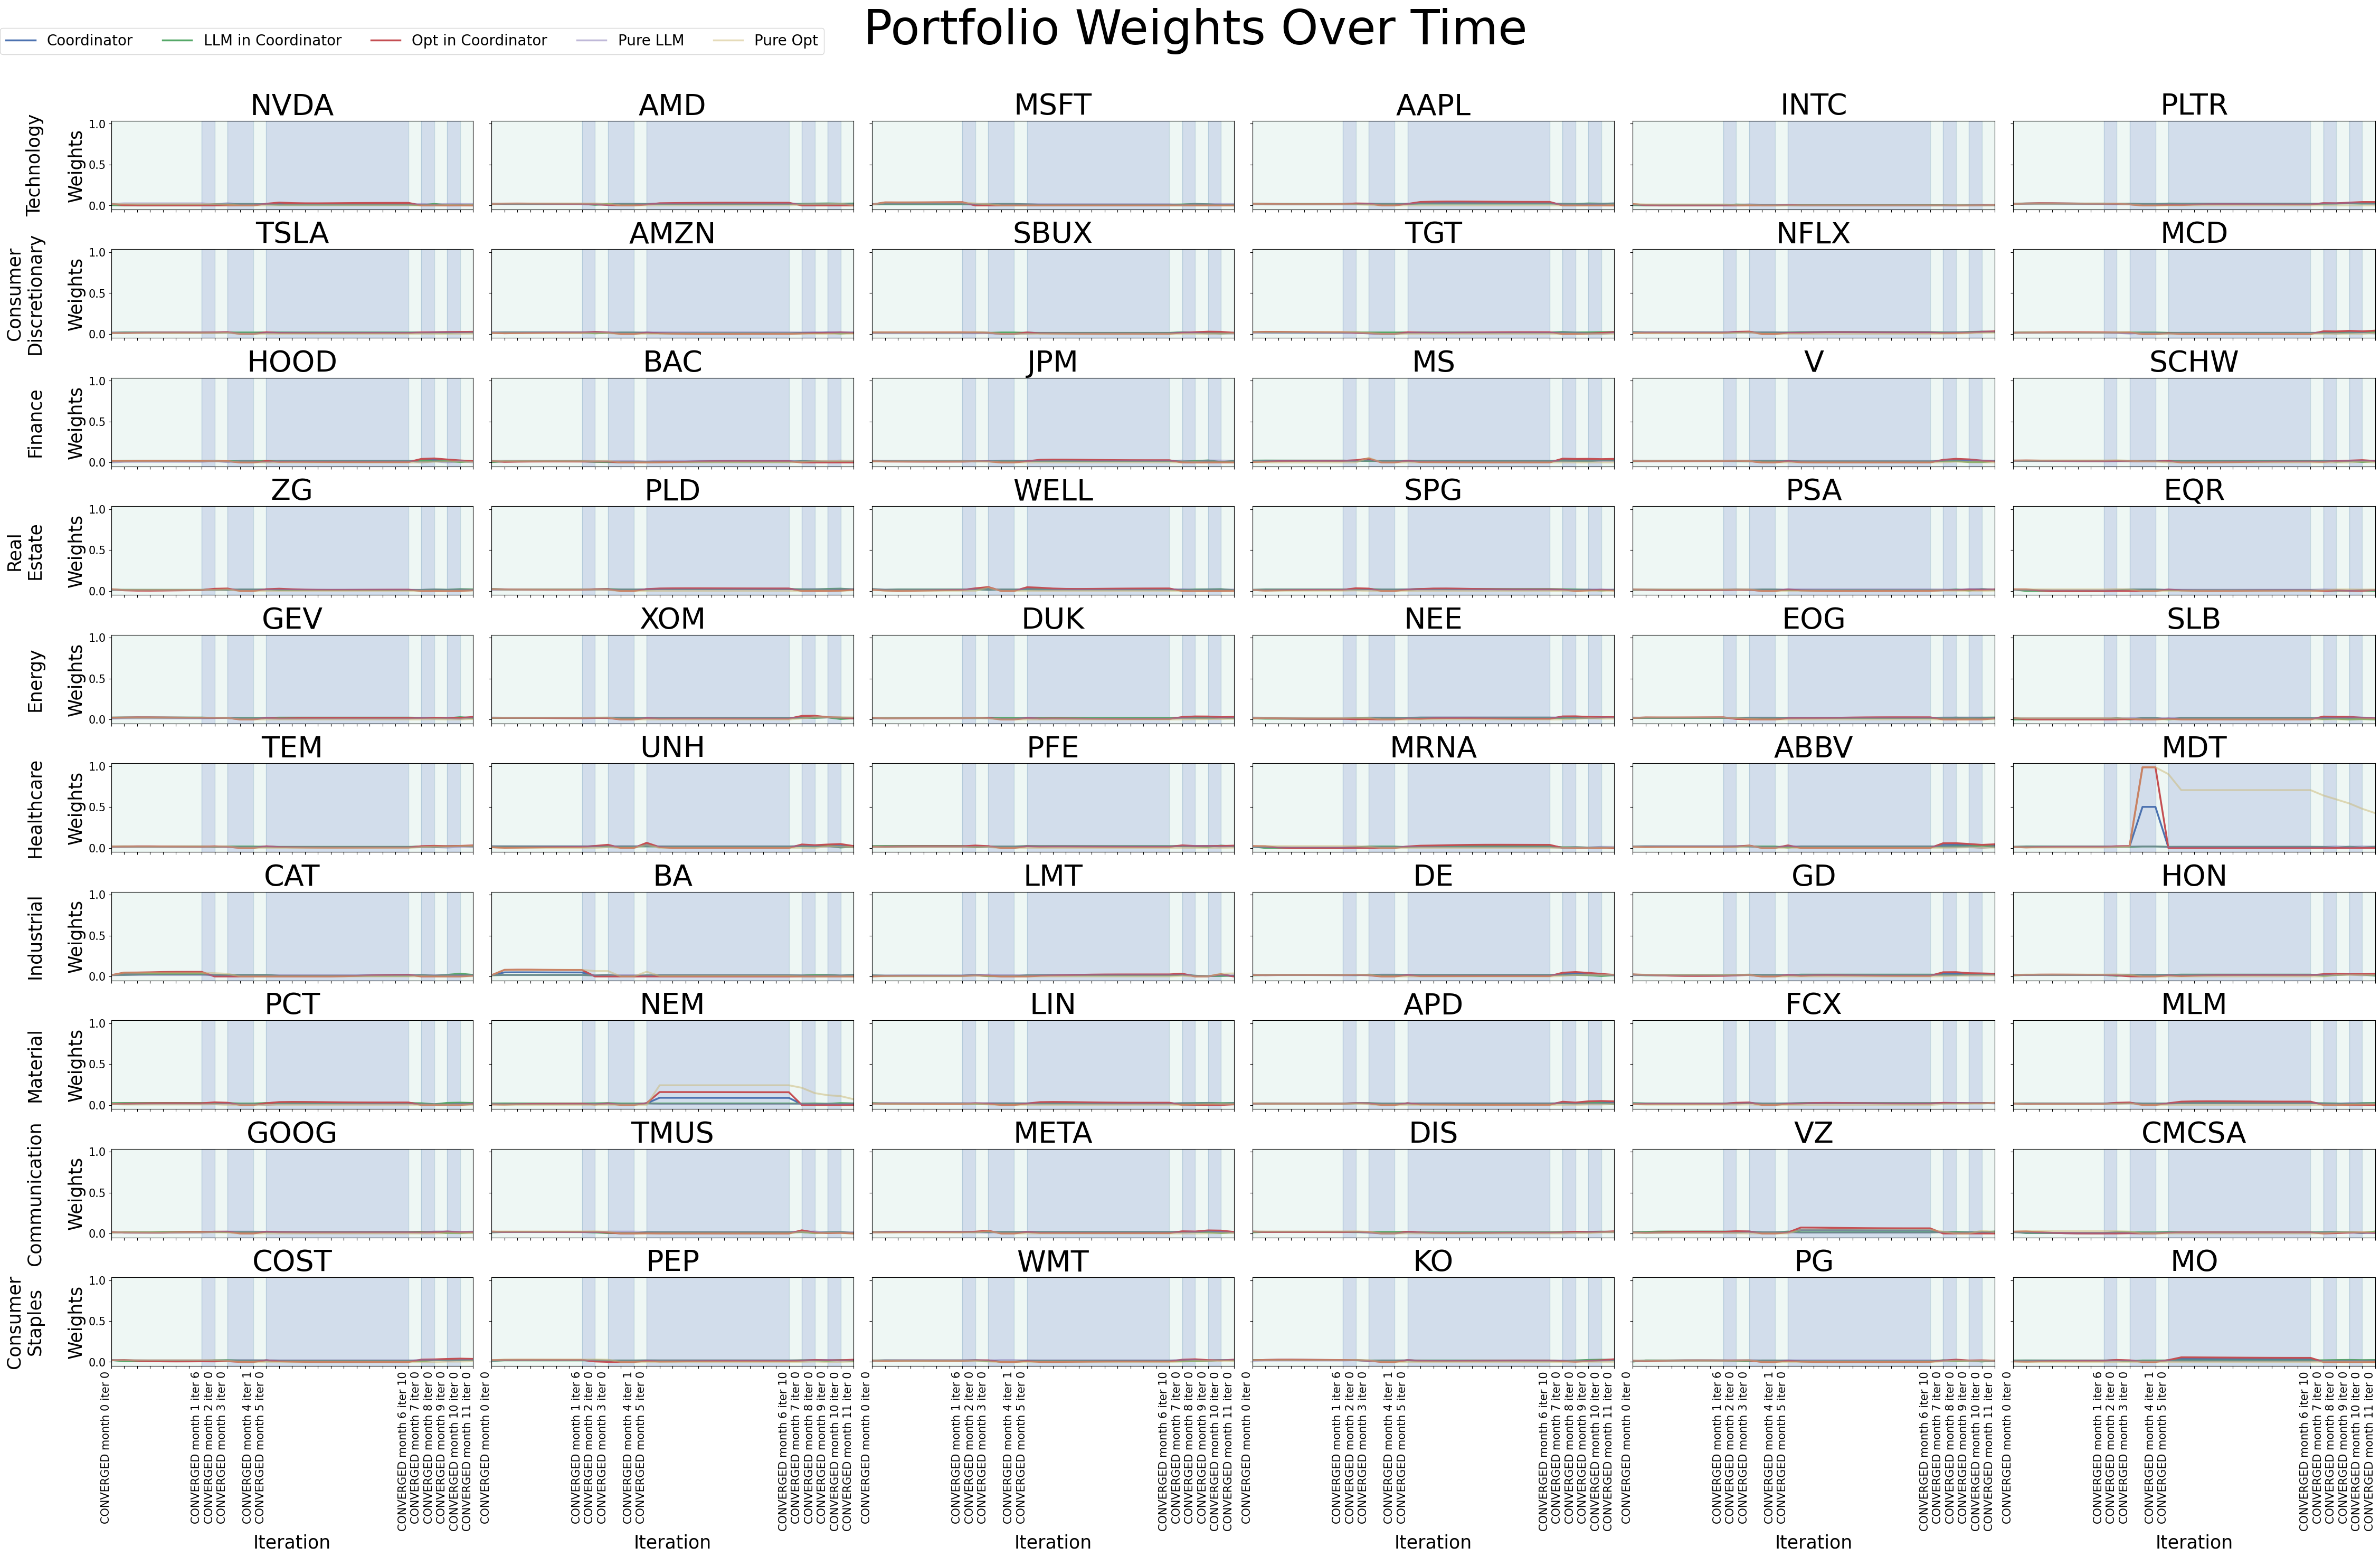

In [159]:
rows = 10
columns = 6

fig, axes = plt.subplots(rows, columns, figsize=(45, 30), sharey=True)
fig.suptitle("Portfolio Weights Over Time\n", fontsize=65)
plt.subplots_adjust(top=0.6)  

# Flatten the 2D array of axes to make it easier to iterate
axes = axes.flatten()

# Define regions and colors
blue_region = (round(108/255, 2), round(143/255, 2), round(191/255, 2), 0.3)
green_region = (round(201/255, 2), round(230/255, 2), round(219/255, 2), 0.3)

days = []
prev = 0

for i, log in enumerate(df['status']):
    log = log.split()
    j = log.index("month")
    cur = log[j+1]
    if cur != prev:
        days.append(i-1)
        prev = cur

days.append(i+1)

regions = []
for i in range(len(days)-1):
    region_color = blue_region if i % 2 == 0 else green_region
    regions.append((days[i], days[i+1], region_color))

# Generate x-tick labels, hiding those without "CONVERGED"
xtick_labels = []
for status in df['status']:
    if "CONVERGED" in status:
        xtick_labels.append(status)
    else:
        xtick_labels.append("")  # Blank label for non-CONVERGED iterations

for i in range(rows * columns):

    isEmpty = False

    try:
        ticker = tickers[i]
    except:
        ticker = None
        isEmpty = True
    
    # Fill regions
    for start, end, color in regions:
        axes[i].axvspan(start, end, color=color, alpha=0.3)

    if ticker:
        # Plot lines
        if i == 0:
            axes[i].plot(df['status'], df[f'all {ticker}'], label='Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], label='LLM in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], label='Opt in Coordinator', linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], label='Pure LLM', linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], label='Pure Opt', linewidth=2.5, alpha=0.5)
        else:
            axes[i].plot(df['status'], df[f'all {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'llm {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], df[f'opt {ticker}'], linewidth=2.5)
            axes[i].plot(df['status'], pure_llm_history[i], linewidth=2.5, alpha=0.5)
            axes[i].plot(df['status'], pure_opt_history[i], linewidth=2.5, alpha=0.5)
        
        # Title and tick parameters
        axes[i].set_title(f'{ticker}', fontsize=40)

    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

    # Set x-tick labels with filtered labels
    axes[i].set_xticks(range(len(df['status'])))
    axes[i].set_xticklabels(xtick_labels, fontsize=15, ha='right')
    
    # X-axis limit
    axes[i].set_xlim(0, len(df['status']) - 1)

    
    # Y-label on first column
    if i in [i for i in range(0, rows*columns, columns)]:
        cat = '\n'.join(stock_categories[i//columns].split())
        axes[i].set_ylabel(f"{cat}\n\nWeights", fontsize=25)
    
    # X-label only on last row
    if i in [i for i in range(rows*columns-columns, rows*columns)]:
        axes[i].set_xlabel("Iteration", fontsize=25)
    else:
        # Hide x-tick labels for the first two rows
        axes[i].tick_params(axis='x', labelbottom=False)

# Add common legend (adjust location as you like)
# fig.legend(loc=(0.00, 0.95), ncol=2, fontsize=20)
fig.legend(loc=(0.00, 0.965), ncol=5, fontsize=20)

plt.tight_layout()

plt.savefig(grid_image_path, dpi=300) # , bbox_inches='tight'  
plt.show()

#### Backtesting
Seeing how the strategies perform based on historical data

In [160]:
# get the beginning price for each month
df_init = df[df['status'].str.contains('iter 0')].reset_index(drop=True)
df_end = df.iloc[[d - 1 for d in days[1:]]].reset_index(drop=True)

In [161]:
def backtest(df, columns=None, weights_=None):
    i = 0

    initial_capital = 10000
    portfolio_value = initial_capital

    portfolio_history = [portfolio_value]

    while i < 11:
        if columns:
            weights = df.loc[i, columns].tolist()
        else:
            weights = weights_[i]

        # 2. -> buy jan 31
        shares = []
        initial_capital = portfolio_value

        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            shares_bought = initial_capital * weights[j] / ticker_price
            shares.append(shares_bought)
            portfolio_value -= shares_bought * ticker_price
            # print(f"{weights[j] = }\t{ticker_price = } -> {shares_bought = }")

        # 3. -> sell feb 31
        i += 1
        for j, ticker in enumerate(tickers):
            ticker_price = data_loaded[i][ticker]['price']
            portfolio_value += shares[j] * ticker_price

        portfolio_history.append(portfolio_value)

    print(portfolio_value)
    return portfolio_history

all_weights = ["all " + ticker for ticker in tickers]

portfolio_history_coordinated = backtest(df_end, columns=all_weights)
portfolio_history_opt = backtest(df_init, weights_=opt_histories)
portfolio_history_llm = backtest(df_init, weights_=llm_histories)

14240.713820022915
13910.342020849486
12948.872273590565


#### Plot the backtesting

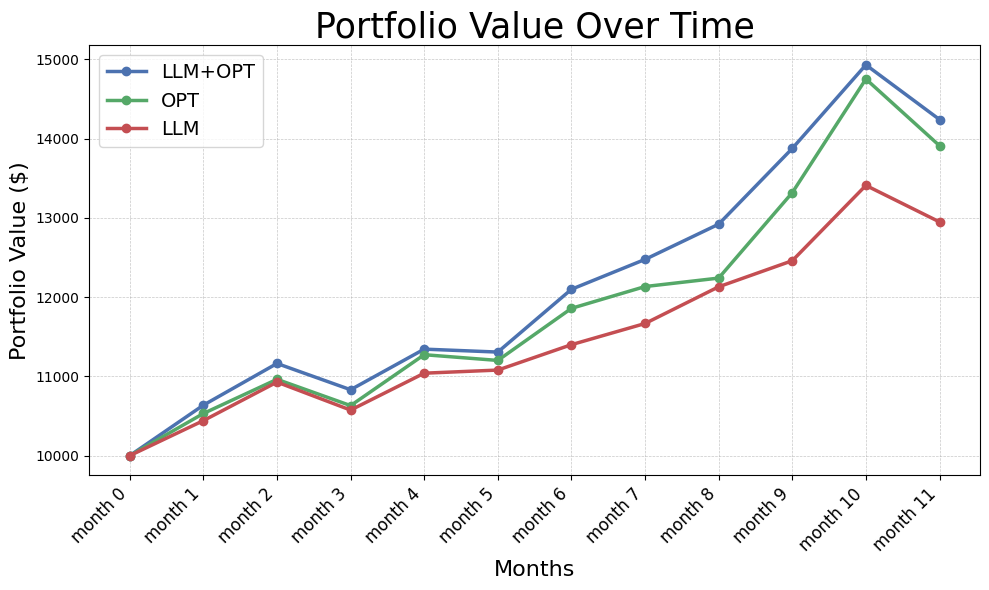

In [162]:
# Create labels for months 0 through 11
months = [f"month {i}" for i in range(12)]

plt.figure(figsize=(10, 6))

# Plot as a line chart with markers
plt.plot(months, portfolio_history_coordinated, linestyle='-', marker='o', linewidth=2.5, label='LLM+OPT')
plt.plot(months, portfolio_history_opt, linestyle='-', marker='o', linewidth=2.5, label='OPT')
plt.plot(months, portfolio_history_llm, linestyle='-', marker='o', linewidth=2.5, label='LLM')

# Add a title, axis labels, and grid
plt.title("Portfolio Value Over Time", fontsize=25)
plt.xlabel("Months", fontsize=16)
plt.ylabel("Portfolio Value ($)", fontsize=16)

# Improve grid styling
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add a legend with larger font size
plt.legend(fontsize=14, loc='upper left')

# Rotate x-tick labels and align them to the right
plt.xticks(fontsize=12, rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.savefig(pft_value_over_time_path, dpi=500, bbox_inches='tight')  
plt.show()